# CAPSTONE

To create a recommender model to assist the Sales & Marketing Department in identifying cross-selling opportunities to our customers through identifying customer segments by applying clustering techniques on customer sales data, including natural language processing of product descriptions to identify product categories.

Deliverables: to deliver a recommender model that improves by at least 10% accuracy from baseline model without feature engineering.

Customer Segementation by 
- RFM: (Recency, Frequency, Monetary) using K-means/DBScan/Hierarchical clustering
https://www.optimove.com/resources/learning-center/customer-segmentation-via-cluster-analysis#:~:text=In%20the%20context%20of%20customer,archetypes%E2%80%9D%20or%20%E2%80%9Cpersonas%E2%80%9D.

https://www.analyticsvidhya.com/blog/2020/10/quick-guide-to-evaluation-metrics-for-supervised-and-unsupervised-machine-learning/

https://www.shopify.com.sg/encyclopedia/customer-segmentation#:~:text=Customer%20segmentation%20is%20the%20process,Number%20of%20employees


https://analyticsindiamag.com/how-to-measure-the-success-of-a-recommendation-system/

https://www.kaggle.com/code/azizozmen/customer-segmentation-cohort-rfm-analysis-k-means

https://www.kaggle.com/code/ozlemilgun/customer-segmentation-using-rfm-analysis

https://www.kaggle.com/code/mathchi/business-problem-with-customer-segmentation

- Product segmentation (categorical) using K modes, Jacard Distance
Categorize products into main categories by performing NLP on product description (parts of speech tagging)

https://www.analyticsvidhya.com/blog/2021/06/kmodes-clustering-algorithm-for-categorical-data/#:~:text=KModes%20clustering%20is%20one%20of,similar%20our%20data%20points%20are.

- Clustering of combination of categorical and numerical features (Gower Distance, Dimensionality Reduction Techniques, K-prototypes)

Dataset only has 8 columns. Segmentation would require feature engineering to identify additional features for clustering. 

Unique product descriptions are about 4000+, which detail product type and variants like colour, design, and number of items it contains.

We would use RFM (Recency, Frequency, Monetary) Analysis to numerical sales data 

8 feature columns, 540K observations
'InvoiceNo' - 25900 unique
'stockcode_caps' - 4070 unique
'description_new' - 4223 unique, includes adjustment entries like stock returns, discounts 
'Quantity'
'InvoiceDate' - 1 year period
'UnitPrice'
'CustomerID' - 4372 unique
'Country' - 38 countries, 91% from one country

Assume average gross margin is 42%, net margin is 7% - online retail
https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/margin.html

https://en.wikipedia.org/wiki/List_of_countries_by_United_Nations_geoscheme

1. What is your problem statement?  What will you actually be doing?

2. Who is your audience?  Why will they care?
 
3. What is your success metric?  How will you know if you are actually solving the problem in a useful way?

4. What is your data source?  What format is your data in?  How much cleaning and munging will be required?

5. What are potential challenges or obstacles and how will you mitigate them?

6. Is this a reasonable project given the time constraints that you have?



Week starting 25 Apr
First half
- Import and clean data
- NLP of product categories
- EDA on product categories
- Product category clustering - K modes
- Create basic recommender model, error analysis, tuning

Second half
- Feature engineering for sales data - RFM analysis
- RFM clustering (K-means)
- Add to recommender model, error analysis, tuning

Week starting 2 May
First half
- Clustering with combined categorical variables and numerical variables
- Add other clustering methods DBScan/ Hierarchical clustering/Gower Distance/ Dimensionality Reduction Techniques/ K-prototypes
- Error analysis, tuning

Second half
Prepare presentation slides
Stretch goal - Impute COGS based on industry assumptions to add dimension to the business proposal

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

import wordcloud
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import cosine_similarity
from sklearn_extra.cluster import KMedoids
import funk_svd

In [2]:
# Set chart style
plt.style.use('fivethirtyeight')

In [3]:
# Set float display options
pd.set_option('display.float_format','{:,.2f}'.format)

In [4]:
# Import data
sales = pd.read_csv('../data/processed_sales.csv', 
                         dtype={'invoiceno': 'object', 
                                 'stockcode_caps': 'object', 
                                 'quantity': np.int32, 
                                 'unitprice': np.float32, 
                                 'customerid': 'object'
                                })

In [5]:
customer_location = pd.read_csv('../data/processed_customer.csv')
stock_descriptions= pd.read_csv('../data/processed_stock_descriptions.csv')
invoice = pd.read_csv('../data/cleaned_invoice.csv')

In [6]:
# Check column types and null values
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279513 entries, 0 to 279512
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   invoiceno       279513 non-null  object 
 1   stockcode_caps  279513 non-null  object 
 2   quantity        279513 non-null  int32  
 3   unitprice       279513 non-null  float32
 4   customerid      279513 non-null  object 
dtypes: float32(1), int32(1), object(3)
memory usage: 8.5+ MB


In [7]:
# Check column types and null values
customer_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5772 entries, 0 to 5771
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerid       5772 non-null   object 
 1   domestic         5772 non-null   bool   
 2   recency_score    5611 non-null   float64
 3   frequency_score  5611 non-null   float64
 4   monetary_score   5611 non-null   float64
 5   cust_matrix      5611 non-null   object 
dtypes: bool(1), float64(3), object(2)
memory usage: 231.2+ KB


In [8]:
# Check column types and null values
stock_descriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3817 entries, 0 to 3816
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   stockcode_caps     3817 non-null   object
 1   description_new    3817 non-null   object
 2   prodsales_deciles  3817 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 89.6+ KB


In [9]:
# Check column types and null values
invoice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23195 entries, 0 to 23194
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   invoiceno    23195 non-null  object
 1   invoicedate  23195 non-null  object
dtypes: object(2)
memory usage: 362.5+ KB


In [10]:
# convert time to datetime
invoice['invoicedate'] = pd.to_datetime(invoice['invoicedate'])

In [11]:
# Merge datasets together
sales_data = sales.merge(customer_location, on='customerid', how='left') \
            .merge(invoice, on='invoiceno',how='left')

In [12]:
# Merge datasets together
sales_data = sales_data.merge(stock_descriptions[['stockcode_caps','prodsales_deciles']],
                              on='stockcode_caps',
                              how='left')

In [13]:
# Calculate revenue from unit price and quantity
sales_data['revenue'] = sales_data['unitprice'] * sales_data['quantity'] 

In [14]:
# create date features
sales_data['yearmonth'] = sales_data['invoicedate'].dt.to_period('M')

In [15]:
# create date features
sales_data['quarter'] = sales_data['invoicedate'].dt.to_period('Q')

In [16]:
# create date features
sales_data['week'] = sales_data['invoicedate'].dt.to_period('W')

### Feature engineering

Exponential decay function, assume effect of relevance decays uniformly over time. 

In [17]:
last_invoice_date = sales_data['invoicedate'].max()

In [18]:
sales_data['invoice_age'] = pd.to_timedelta(last_invoice_date
                                            - sales_data['invoicedate']) / np.timedelta64(1, "D")

In [19]:
sales_data['decay_3M'] = np.exp(np.log(0.5) / 90 * sales_data['invoice_age'])

In [20]:
sales_data['decay_2M'] = np.exp(np.log(0.5) / 60 * sales_data['invoice_age'])

In [21]:
sales_data['decay_1M'] = np.exp(np.log(0.5) / 30 * sales_data['invoice_age'])

In [22]:
sales_data['revenue_decay_3M'] = sales_data['revenue'] * sales_data['decay_3M']

In [23]:
sales_data['revenue_decay_2M'] = sales_data['revenue'] * sales_data['decay_2M']

In [24]:
sales_data['revenue_decay_1M'] = sales_data['revenue'] * sales_data['decay_1M']

In [25]:
sales_data

,invoiceno,stockcode_caps,quantity,unitprice,customerid,domestic,recency_score,frequency_score,monetary_score,cust_matrix,...,yearmonth,quarter,week,invoice_age,decay_3M,decay_2M,decay_1M,revenue_decay_3M,revenue_decay_2M,revenue_decay_1M
0,537626,21064,6,5.95,12347,False,3.00,3.00,3.00,star_cust,...,2010-12,2010Q4,2010-12-06/2010-12-12,366.91,0.06,0.01,0.00,2.12,0.52,0.01
1,537626,21731,12,1.65,12347,False,3.00,3.00,3.00,star_cust,...,2010-12,2010Q4,2010-12-06/2010-12-12,366.91,0.06,0.01,0.00,1.17,0.29,0.00
2,537626,22195,12,1.65,12347,False,3.00,3.00,3.00,star_cust,...,2010-12,2010Q4,2010-12-06/2010-12-12,366.91,0.06,0.01,0.00,1.17,0.29,0.00
3,537626,22212,6,2.10,12347,False,3.00,3.00,3.00,star_cust,...,2010-12,2010Q4,2010-12-06/2010-12-12,366.91,0.06,0.01,0.00,0.75,0.18,0.00
4,537626,22375,4,4.25,12347,False,3.00,3.00,3.00,star_cust,...,2010-12,2010Q4,2010-12-06/2010-12-12,366.91,0.06,0.01,0.00,1.01,0.25,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279508,581498,85049E,4,3.29,581498,True,3.00,2.00,3.00,new_cust,...,2011-12,2011Q4,2011-12-05/2011-12-11,0.10,1.00,1.00,1.00,13.15,13.14,13.13
279509,581498,85099B,5,4.13,581498,True,3.00,2.00,3.00,new_cust,...,2011-12,2011Q4,2011-12-05/2011-12-11,0.10,1.00,1.00,1.00,20.63,20.63,20.60
279510,581498,85099C,4,4.13,581498,True,3.00,2.00,3.00,new_cust,...,2011-12,2011Q4,2011-12-05/2011-12-11,0.10,1.00,1.00,1.00,16.51,16.50,16.48
279511,581498,85150,1,4.96,581498,True,3.00,2.00,3.00,new_cust,...,2011-12,2011Q4,2011-12-05/2011-12-11,0.10,1.00,1.00,1.00,4.96,4.95,4.95


### Train Test split

In [26]:
# Invoice date combinations
sales_by_invoice = sales_data.groupby(['customerid','invoiceno','invoicedate','yearmonth']) \
                                    .agg(total_revenue=('revenue',np.sum)) \
                                    .reset_index()

In [27]:
sales_by_invoice[sales_by_invoice['yearmonth']=='2011-12']

,customerid,invoiceno,invoicedate,yearmonth,total_revenue
6,12347,581180,2011-12-07 15:52:00,2011-12,181.02
20,12358,581232,2011-12-08 10:26:00,2011-12,523.20
33,12362,580979,2011-12-06 15:40:00,2011-12,475.04
40,12364,580152,2011-12-02 10:22:00,2011-12,172.68
47,12375,C581071,2011-12-07 11:27:00,2011-12,-2.08
...,...,...,...,...,...
15540,581256,581256,2011-12-08 11:21:00,2011-12,"4,839.42"
15541,581439,581439,2011-12-08 16:30:00,2011-12,"5,091.97"
15542,581492,581492,2011-12-09 10:03:00,2011-12,"5,618.71"
15543,581497,581497,2011-12-09 10:23:00,2011-12,"3,217.20"


In [28]:
sales_by_invoice_excl_return = sales_by_invoice[sales_by_invoice['total_revenue']>0]

In [29]:
# select latest sales invoice of each customer
latest_sales_invoices = sales_by_invoice_excl_return.loc[sales_by_invoice_excl_return
                                                     .groupby('customerid').invoicedate.idxmax()]

In [30]:
latest_sales_invoices['invoicedate'].max()

Timestamp('2011-12-09 12:50:00')

In [31]:
latest_sales_invoices['invoicedate'].min()

Timestamp('2011-10-17 13:19:00')

In [32]:
latest_sales_invoices.groupby('yearmonth').sum()

,total_revenue
yearmonth,
2011-10,"121,575.09"
2011-11,"659,432.83"
2011-12,"307,494.60"


In [33]:
# Create column to indicate test data and prepopulate with 'False'
sales_data["test"] = False

In [34]:
# Select all products in the latest sales invoice of each customer and assign True
sales_data.loc[sales_data['invoiceno'].isin(latest_sales_invoices['invoiceno']), "test"] = True

In [35]:
# split test data
test_data = sales_data[sales_data['test']==True].copy()

In [36]:
# assign sales_data as test_data
train_data = sales_data

In [37]:
test_data.groupby('invoiceno').agg(countproducts=('stockcode_caps',np.size)).describe()

,countproducts
count,"1,856.00"
mean,31.79
std,65.99
min,1.00
25%,7.00
50%,15.00
75%,29.00
max,787.00


In [38]:
test_invoices = sales_data[sales_data['test'] == True].groupby(['invoiceno',
                                                                'customerid',
                                                               'invoicedate',]) \
                                                    .agg(num_products=('stockcode_caps',np.size),                                      
                                                   ).reset_index()

In [39]:
test_invoices['invoice_age'] = pd.to_timedelta(last_invoice_date
                                            - test_invoices['invoicedate']) / np.timedelta64(1, "D")

In [40]:
test_data['cust_stock'] = test_data['customerid'] + '/' + test_data['stockcode_caps']

### Recommender Models

Basic ranking system based on Total Revenue

In [41]:
# for each invoice: 
predict_data = []
for i in test_invoices['invoiceno'].values:
    predict_invoice = []
    past_products = []
    test_customerid = test_invoices.loc[test_invoices['invoiceno'] == i,'customerid'].item()
    test_invoicedate = test_invoices.loc[test_invoices['invoiceno'] == i,'invoicedate'].item()
    test_numproducts = test_invoices.loc[test_invoices['invoiceno'] == i,'num_products'].item()
    

    # select all sales before test invoice date
    past_all_invoices = train_data.loc[(train_data['invoicedate']<test_invoicedate),
                       ['stockcode_caps','revenue']] \
                        .groupby(['stockcode_caps']) \
                        .sum().reset_index()
    past_all_invoices['customerid'] = test_customerid
    past_all_purchases = past_all_invoices[past_all_invoices['revenue']>0]
    predict_invoice.extend(past_all_purchases[['customerid','stockcode_caps','revenue']] \
                        .sort_values(by='revenue',ascending=False) \
                        .head(10).values.tolist())   
    predict_data.extend(predict_invoice)

In [42]:
# compile prediction results
predict_data = pd.DataFrame(predict_data, columns=['customerid','stockcode_caps','revenue'])
predict_data['model'] = 'top10'
predict_data['cust_stock'] = predict_data['customerid'] + '/' + predict_data['stockcode_caps']
predict_data['hit_rate'] = predict_data['cust_stock'].isin(test_data['cust_stock'])
predict_data['predicted_revenue'] = predict_data[['cust_stock']] \
                                            .merge(test_data[['cust_stock','revenue']],
                                                       on='cust_stock',
                                                       how='left',
                                                      ).fillna(0)['revenue']

In [43]:
# create dataframe to store all predictions
predict_all = predict_data[['customerid','stockcode_caps','model','hit_rate','predicted_revenue']]

In [184]:
# for each invoice: 
predict_data = []
for i in test_invoices['invoiceno'].values:
    predict_invoice = []
    past_products = []
    test_customerid = test_invoices.loc[test_invoices['invoiceno'] == i,'customerid'].item()
    test_invoicedate = test_invoices.loc[test_invoices['invoiceno'] == i,'invoicedate'].item()
    test_numproducts = test_invoices.loc[test_invoices['invoiceno'] == i,'num_products'].item()
    

    # select all sales before test invoice date
    past_all_invoices = train_data.loc[(train_data['invoicedate']<test_invoicedate),
                       ['stockcode_caps','revenue_decay_1M']] \
                        .groupby(['stockcode_caps']) \
                        .sum().reset_index()
    past_all_invoices['customerid'] = test_customerid
    past_all_purchases = past_all_invoices[past_all_invoices['revenue_decay_1M']>0]
    predict_invoice.extend(past_all_purchases[['customerid','stockcode_caps','revenue_decay_1M']] \
                        .sort_values(by='revenue_decay_1M',ascending=False) \
                        .head(10).values.tolist())   
    predict_data.extend(predict_invoice)

In [188]:
# compile prediction results
predict_data = pd.DataFrame(predict_data, columns=['customerid','stockcode_caps','revenue'])
predict_data['model'] = 'top10_1m'
predict_data['cust_stock'] = predict_data['customerid'] + '/' + predict_data['stockcode_caps']
predict_data['hit_rate'] = predict_data['cust_stock'].isin(test_data['cust_stock'])
predict_data['predicted_revenue'] = predict_data[['cust_stock']] \
                                            .merge(test_data[['cust_stock','revenue']],
                                                       on='cust_stock',
                                                       how='left',
                                                      ).fillna(0)['revenue']

In [189]:
# concat to prediction database
predict_all = pd.concat([predict_all, predict_data], join = 'inner', ignore_index=True)

Personalized ranking system

In [47]:
def personalized_ranking(revenue='revenue',num_predict=10, model_name='ranking'):
    # for each invoice: 
    predict_data = []
    for i in test_invoices['invoiceno'].values:
        predict_invoice = []
        past_products = []
        test_customerid = test_invoices.loc[test_invoices['invoiceno'] == i,'customerid'].item()
        test_invoicedate = test_invoices.loc[test_invoices['invoiceno'] == i,'invoicedate'].item()

        # sums all previous invoices of each customerid
        past_cust_invoices = train_data.loc[(train_data['customerid']==test_customerid) & 
                                            (train_data['invoicedate']<test_invoicedate),
                           ['customerid','stockcode_caps',revenue]] \
                            .groupby(['customerid','stockcode_caps']) \
                            .sum().reset_index()

        # compare number of products in test invoice 
        # vs unique products with positive sales in all past invoices
        past_cust_purchases = past_cust_invoices[past_cust_invoices[revenue]>0]
        past_products.extend(past_cust_purchases['stockcode_caps'])

        if past_cust_purchases.shape[0] > 0:
        # if there were past purchases for this customer         
            invoice_count_difference = past_cust_purchases.shape[0] - num_predict       
            if invoice_count_difference >= 0:                                                 
            # and if the past purchases had more products than the test invoice
            # select the top n products where n = product length of test invoice
                predict_data.extend(past_cust_purchases.head(num_predict).values.tolist())

            else:
            # else, being that the past puchases were fewer than test invoice,
            # add the products from past purchases, 
                predict_data.extend(past_cust_purchases.values.tolist())
            # and add additional products from all past invoices
            # to make up for the shortfall in products
                past_all_invoices = train_data.loc[(train_data['invoicedate']<test_invoicedate),
                                   ['stockcode_caps',revenue]] \
                                    .groupby(['stockcode_caps']) \
                                    .sum().reset_index()
                past_all_invoices['customerid'] = test_customerid
                past_all_purchases = past_all_invoices[past_all_invoices[revenue]>0]      
                # select products that are not in past_products list
                past_all_purchases_select = past_all_purchases[~past_all_purchases
                                                ['stockcode_caps'].isin(past_products)]
                predict_invoice.extend(past_all_purchases_select[['customerid',
                                                                  'stockcode_caps',
                                                                  revenue]] \
                                    .sort_values(by=revenue,ascending=False) \
                                    .head(-invoice_count_difference).values.tolist())   
        else:
        # else, being that there were no past purchases 
        # select all sales before test invoice date
            past_all_invoices = train_data.loc[(train_data['invoicedate']<test_invoicedate),
                               ['stockcode_caps',revenue]] \
                                .groupby(['stockcode_caps']) \
                                .sum().reset_index()
            past_all_invoices['customerid'] = test_customerid
            past_all_purchases = past_all_invoices[past_all_invoices[revenue]>0]
            predict_invoice.extend(past_all_purchases[['customerid','stockcode_caps',revenue]] \
                                .sort_values(by=revenue,ascending=False) \
                                .head(num_predict).values.tolist())   
        
        predict_data.extend(predict_invoice)
    
    # compile prediction results
    predict_data = pd.DataFrame(predict_data, columns=['customerid','stockcode_caps','revenue'])
    predict_data['model'] = model_name
    predict_data['cust_stock'] = predict_data['customerid'] + '/' + predict_data['stockcode_caps']
    predict_data['hit_rate'] = predict_data['cust_stock'].isin(test_data['cust_stock'])
    predict_data['predicted_revenue'] = predict_data[['cust_stock']] \
                                                .merge(test_data[['cust_stock','revenue']],
                                                           on='cust_stock',
                                                           how='left',
                                                          ).fillna(0)['revenue']

    return predict_data

In [48]:
predict_data = personalized_ranking(revenue='revenue',num_predict=10,model_name='ranking')

In [49]:
# compile prediction results
predict_data = pd.DataFrame(predict_data, columns=['customerid','stockcode_caps','revenue'])
predict_data['model'] = 'ranking'
predict_data['cust_stock'] = predict_data['customerid'] + '/' + predict_data['stockcode_caps']
predict_data['hit_rate'] = predict_data['cust_stock'].isin(test_data['cust_stock'])
predict_data['predicted_revenue'] = predict_data[['cust_stock']] \
                                            .merge(test_data[['cust_stock','revenue']],
                                                       on='cust_stock',
                                                       how='left',
                                                      ).fillna(0)['revenue']

In [50]:
# concat to prediction database
predict_all = pd.concat([predict_all, predict_data], join = 'inner', ignore_index=True)

In [51]:
# view prediction hit rate and predicted revenue
predict_all.groupby('model').agg(hit_rate = ('hit_rate',np.mean),
                                   predicted_revenue = ('predicted_revenue',np.sum))

,hit_rate,predicted_revenue
model,,
ranking,0.14,"128,063.58"
top10,0.09,"102,709.34"
top10_1m,0.11,"120,728.90"


Revenue decay

In [52]:
# for each invoice: 
predict_data = []
for i in test_invoices['invoiceno'].values:
    predict_invoice = []
    past_products = []
    test_customerid = test_invoices.loc[test_invoices['invoiceno'] == i,'customerid'].item()
    test_invoicedate = test_invoices.loc[test_invoices['invoiceno'] == i,'invoicedate'].item()
    
    # sums all previous invoices of each customerid
    past_cust_invoices = train_data.loc[(train_data['customerid']==test_customerid) & 
                                        (train_data['invoicedate']<test_invoicedate),
                       ['customerid','stockcode_caps','revenue_decay_1M']] \
                        .groupby(['customerid','stockcode_caps']) \
                        .sum().reset_index()
                                         
    # compare number of products in test invoice 
    # vs unique products with positive sales in all past invoices
    past_cust_purchases = past_cust_invoices[past_cust_invoices['revenue_decay_1M']>0]
    past_products.extend(past_cust_purchases['stockcode_caps'])
    
    if past_cust_purchases.shape[0] > 0:
    # if there were past purchases for this customer         
        invoice_count_difference = past_cust_purchases.shape[0] - 10       
        if invoice_count_difference >= 0:                                                 
        # and if the past purchases had more products than the test invoice
        # select the top n products where n = product length of test invoice
            predict_data.extend(past_cust_purchases.head(10).values.tolist())
        
        else:
        # else, being that the past puchases were fewer than test invoice,
        # add the products from past purchases, 
            predict_data.extend(past_cust_purchases.values.tolist())
        # and add additional products from all past invoices
        # to make up for the shortfall in products
            past_all_invoices = train_data.loc[(train_data['invoicedate']<test_invoicedate),
                               ['stockcode_caps','revenue_decay_1M']] \
                                .groupby(['stockcode_caps']) \
                                .sum().reset_index()
            past_all_invoices['customerid'] = test_customerid
            past_all_purchases = past_all_invoices[past_all_invoices['revenue_decay_1M']>0]      
            past_all_purchases_select = past_all_purchases[~past_all_purchases['stockcode_caps'].isin(
                past_products)]
            predict_invoice.extend(past_all_purchases_select[['customerid',
                                                              'stockcode_caps',
                                                              'revenue_decay_1M']] \
                                .sort_values(by='revenue_decay_1M',ascending=False) \
                                .head(-invoice_count_difference).values.tolist())   
    else:
    # else, being that there were no past purchases 
    # select all sales before test invoice date
        past_all_invoices = train_data.loc[(train_data['invoicedate']<test_invoicedate),
                           ['stockcode_caps','revenue_decay_1M']] \
                            .groupby(['stockcode_caps']) \
                            .sum().reset_index()
        past_all_invoices['customerid'] = test_customerid
        past_all_purchases = past_all_invoices[past_all_invoices['revenue_decay_1M']>0]
        predict_invoice.extend(past_all_purchases[['customerid','stockcode_caps','revenue_decay_1M']] \
                            .sort_values(by='revenue_decay_1M',ascending=False) \
                            .head(10).values.tolist())   
    predict_data.extend(predict_invoice)

In [53]:
# compile prediction results
predict_data = pd.DataFrame(predict_data, columns=['customerid','stockcode_caps','revenue'])
predict_data['model'] = 'ranking1m'
predict_data['cust_stock'] = predict_data['customerid'] + '/' + predict_data['stockcode_caps']
predict_data['hit_rate'] = predict_data['cust_stock'].isin(test_data['cust_stock'])
predict_data['predicted_revenue'] = predict_data[['cust_stock']] \
                                            .merge(test_data[['cust_stock','revenue']],
                                                       on='cust_stock',
                                                       how='left',
                                                      ).fillna(0)['revenue']

In [54]:
# concat to prediction database
predict_all = pd.concat([predict_all, predict_data], join = 'inner', ignore_index=True)

In [55]:
# view prediction hit rate and predicted revenue
predict_all.groupby('model').agg(hit_rate = ('hit_rate',np.mean),
                                   predicted_revenue = ('predicted_revenue',np.sum))

,hit_rate,predicted_revenue
model,,
ranking,0.14,"128,063.58"
ranking1m,0.15,"142,207.14"
top10,0.09,"102,709.34"
top10_1m,0.11,"120,728.90"


#### Adaptive nearest neighbour

In [56]:
# select all customers with prior sales
cust_with_prior_sales = test_invoices[test_invoices['customerid'].isin(
                            # test_invoice customerids which are in
                            sales_data.loc[(sales_data['revenue']>0) &
                                # sales_data excluding the invoices that are in test_invoices
                                ~(sales_data['invoiceno'].isin(
                                    test_invoices['invoiceno'])),'customerid'])]

In [385]:
cust_with_prior_sales

,invoiceno,customerid,invoicedate,num_products,invoice_age
0,571433,13015,2011-10-17 13:19:00,83,52.98
1,571435,14211,2011-10-17 13:23:00,23,52.98
2,571445,12463,2011-10-17 13:44:00,17,52.96
3,571474,16389,2011-10-17 14:41:00,11,52.92
4,571477,12794,2011-10-17 14:54:00,20,52.91
...,...,...,...,...,...
1851,581582,17581,2011-12-09 12:21:00,2,0.02
1852,581584,13777,2011-12-09 12:25:00,1,0.02
1853,581585,15804,2011-12-09 12:31:00,18,0.01
1854,581586,13113,2011-12-09 12:49:00,4,0.00


In [57]:
# select date prior to test invoice date for all customers
predict_data = []
for i in test_invoices['invoiceno'].values:
    predict_invoice = []
    past_products = []
    test_customerid = test_invoices.loc[test_invoices['invoiceno'] == i,'customerid'].item()
    test_invoicedate = test_invoices.loc[test_invoices['invoiceno'] == i,'invoicedate'].item()
    
    if i in cust_with_prior_sales['customerid'].values:
        # sums all previous invoices of each customerid
        past_invoices = sales_prior[sales_prior['invoicedate']<test_invoicedate]

        # create cross tabulation by customerid as index and stockcodes as columns 
        # with sum of revenue as value
        past_invoices_cross = pd.crosstab(index=past_invoices['customerid'],
                                            columns=past_invoices['stockcode_caps'],
                                            values=past_invoices['revenue'], 
                                            aggfunc=sum,
                                            normalize='index',
                                           )

        # calculate cosine similarity between test customer and all other customers
        cust_similarity = cosine_similarity(past_invoices_cross.loc[[test_customerid]],
                          past_invoices_cross.drop(test_customerid))

        # select customer that is the nearest neighbour based on cosine similarity 
        nearest_neighbor = pd.DataFrame(cust_similarity.T , 
                                index=past_invoices_cross.drop(test_customerid).index,
                                columns=['similarity']
                               )['similarity'].idxmax()

        # create table of summary of all invoices of nearest neighbour
        nearest_neighbor_invoices = sales_data[(sales_data['customerid'] == nearest_neighbor) &
               (sales_data['invoicedate'] < test_invoicedate)
               ].groupby('invoiceno') \
                                    .agg(total_revenue = ('revenue',np.sum),
                                        stockcode_caps = ('stockcode_caps',np.size),
                                         invoicedate = ('invoicedate',np.min)
                                        ).sort_values(by='invoicedate', ascending=False)

        # for number of positive invoices
        for j in range(nearest_neighbor_invoices[nearest_neighbor_invoices['total_revenue']>0].shape[0]):

            invoice_slice = sales_data[sales_data['invoiceno'].isin(
                    nearest_neighbor_invoices[nearest_neighbor_invoices['total_revenue']>0].index[0:j+1]
                )].groupby('stockcode_caps').agg(revenue_decay_1M=('revenue_decay_1M',np.sum)) \
                    .sort_values(by='revenue_decay_1M', ascending=False).reset_index()
            product_count = invoice_slice.shape[0]

            if product_count > 10:
            # if products are more than test invoice
                invoice_slice['customerid'] = test_customerid
                invoice_slice.head(10)
                predict_invoice.extend(invoice_slice[['customerid','stockcode_caps','revenue_decay_1M']] \
                            .head(10).values.tolist())      

            else: 
            # if not enough products
                continue

            # append to list
            invoice_slice['customerid'] = test_customerid
            invoice_slice.head(10)
            predict_invoice.extend(invoice_slice[['customerid','stockcode_caps','revenue_decay_1M']] \
                        .head(10).values.tolist()) 
            
        predict_data.extend(predict_invoice)

    else:
    # else, being that there were no past purchases 
    # select all sales before test invoice date
        past_all_invoices = train_data.loc[(train_data['invoicedate']<test_invoicedate),
                           ['stockcode_caps','revenue_decay_1M']] \
                            .groupby(['stockcode_caps']) \
                            .sum().reset_index()
        past_all_invoices['customerid'] = test_customerid
        past_all_purchases = past_all_invoices[past_all_invoices['revenue_decay_1M']>0]
        predict_invoice.extend(past_all_purchases[['customerid','stockcode_caps','revenue_decay_1M']] \
                            .sort_values(by='revenue_decay_1M',ascending=False) \
                            .head(10).values.tolist())   
   
        predict_data.extend(predict_invoice)
        



In [58]:
# compile prediction results
predict_data = pd.DataFrame(predict_data, columns=['customerid','stockcode_caps','revenue'])
predict_data['model'] = 'nearestneighbour'
predict_data['cust_stock'] = predict_data['customerid'] + '/' + predict_data['stockcode_caps']
predict_data['hit_rate'] = predict_data['cust_stock'].isin(test_data['cust_stock'])
predict_data['predicted_revenue'] = predict_data[['cust_stock']] \
                                            .merge(test_data[['cust_stock','revenue']],
                                                       on='cust_stock',
                                                       how='left',
                                                      ).fillna(0)['revenue']

In [59]:
# concat to prediction database
predict_all = pd.concat([predict_all, predict_data], join = 'inner', ignore_index=True)

In [60]:
# view prediction hit rate and predicted revenue
predict_all.groupby('model').agg(hit_rate = ('hit_rate',np.mean),
                                   predicted_revenue = ('predicted_revenue',np.sum))

,hit_rate,predicted_revenue
model,,
nearestneighbour,0.11,"120,728.90"
ranking,0.14,"128,063.58"
ranking1m,0.15,"142,207.14"
top10,0.09,"102,709.34"
top10_1m,0.11,"120,728.90"


Trending

In [61]:
current_date = sales_data['invoicedate'].max()

In [62]:
sales_data['age'] = sales_data['invoicedate'] - current_date

In [63]:
sales_data['age'] = sales_data['age'].dt.days

In [64]:
sale_by_day = sales_data.pivot_table(index='stockcode_caps', 
                                     columns='age', 
                                     values='revenue',
                                    aggfunc='sum',
                                    fill_value=0)

In [65]:
sale_by_day_decile1 = sales_data[sales_data['prodsales_deciles']==1] \
                                .pivot_table(index='stockcode_caps', 
                                             columns='age', 
                                             values='revenue',
                                            aggfunc='sum',
                                            fill_value=0)

In [66]:
def smooth(series, window_size, window):

    # Generate data points 'outside' of x on either side to ensure
    # the smoothing window can operate everywhere
    ext = np.r_[2 * series[0] - series[window_size-1::-1],
                series,
                2 * series[-1] - series[-1:-window_size:-1]]
    weights = window(window_size)
    smoothed = np.convolve(weights / weights.sum(), ext, mode='same')
    return smoothed[window_size:-window_size+1]  # trim away the excess data

In [67]:
trend = sale_by_day.loc[pd.IndexSlice['22086'], :].values

In [68]:
trend = sale_by_day.loc[pd.IndexSlice['22086'], :].values
x = np.arange(-len(trend),0)

In [69]:
def smooth2(series, window_size, window):
    ext = np.r_[2 * series[0] - series[window_size-1::-1],
                series,
                2 * series[-1] - series[-1:-window_size:-1]]
    weights = window(window_size)
    smoothed = np.convolve(weights / weights.sum(), ext, mode='same')
    return smoothed[window_size:-window_size+1]

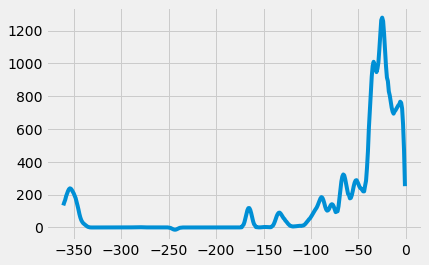

In [70]:
smoothed = smooth(
    trend,
    14,
    np.hamming
)
plt.plot(x, smoothed, label="Smoothed")

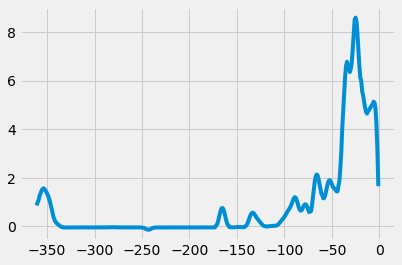

In [71]:
def standardize(series):
    iqr = np.percentile(series, 75) - np.percentile(series, 25)
    return (series - np.median(series)) / iqr

smoothed_std = standardize(smoothed)
plt.plot(x, smoothed_std)

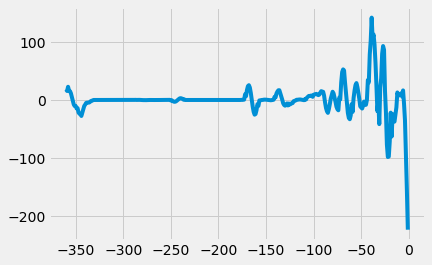

In [72]:
slopes = smoothed[1:]-smoothed[:-1]
plt.plot(x[1:], slopes)

In [73]:
import pandas as pd
import numpy as np
import operator

def trend_engine(dataset=sale_by_day, 
                 smoothing_window_size=14, 
                 smoothing_window_function = np.hamming,
                 standardize = False
                ):
    trends = dataset
    trend_scores = {}

    for i in trends.index:
        trend = trends.loc[pd.IndexSlice[i], :].values
        smoothed = smooth(trend, smoothing_window_size, smoothing_window_function)
        if standardize == False:
            nsmoothed = smoothed
        if standardize == True:
            nsmoothed = standardizer(smoothed)
        slopes = nsmoothed[1:] - nsmoothed[:-1]
        trend_scores[i] = slopes
    return trend_scores

def smooth(series, window_size, window):
    ext = np.r_[2 * series[0] - series[window_size-1::-1],
                series,
                2 * series[-1] - series[-1:-window_size:-1]]
    weights = window(window_size)
    smoothed = np.convolve(weights / weights.sum(), ext, mode='same')
    return smoothed[window_size:-window_size+1]

def standardizer(series):
    iqr = np.percentile(series, 75) - np.percentile(series, 25)
    print(iqr)
    return (series - np.median(series)) / iqr


In [74]:
trending = trend_engine(dataset=sale_by_day, 
                        smoothing_window_size=14, 
                        smoothing_window_function = np.hamming,
                        standardize=False)

In [75]:
trending_df = pd.DataFrame.from_dict(trending, columns=x[1:],orient='index')

In [76]:
predict = pd.DataFrame(trending_df[-50].sort_values(ascending=False).head(5).index)

In [77]:
# for each invoice: 
predict_data = []
for i in test_invoices['invoiceno'].values:
    predict_invoice = []
    test_invoiceage = test_invoices.loc[test_invoices['invoiceno'] == i,'invoice_age'].item()
    test_customerid = test_invoices.loc[test_invoices['invoiceno'] == i,'customerid'].item()
    
    predict = pd.DataFrame(trending_df[np.ceil(-test_invoiceage)-1] \
                            .sort_values(ascending=False)[0:10].index)
    predict['customerid'] = test_customerid
    predict_data.extend(predict.values.tolist())     

In [78]:
predict_data

[['23556', '13015'],
 ['23554', '13015'],
 ['23555', '13015'],
 ['23558', '13015'],
 ['23557', '13015'],
 ['23553', '13015'],
 ['23485', '13015'],
 ['22423', '13015'],
 ['22595', '13015'],
 ['84347', '13015'],
 ['23556', '14211'],
 ['23554', '14211'],
 ['23555', '14211'],
 ['23558', '14211'],
 ['23557', '14211'],
 ['23553', '14211'],
 ['23485', '14211'],
 ['22423', '14211'],
 ['22595', '14211'],
 ['84347', '14211'],
 ['23556', '12463'],
 ['23554', '12463'],
 ['23555', '12463'],
 ['23558', '12463'],
 ['23557', '12463'],
 ['23553', '12463'],
 ['23485', '12463'],
 ['22423', '12463'],
 ['22595', '12463'],
 ['84347', '12463'],
 ['23556', '16389'],
 ['23554', '16389'],
 ['23555', '16389'],
 ['23558', '16389'],
 ['23557', '16389'],
 ['23553', '16389'],
 ['23485', '16389'],
 ['22423', '16389'],
 ['22595', '16389'],
 ['84347', '16389'],
 ['23556', '12794'],
 ['23554', '12794'],
 ['23555', '12794'],
 ['23558', '12794'],
 ['23557', '12794'],
 ['23553', '12794'],
 ['23485', '12794'],
 ['22423', '1

In [79]:
# compile prediction results
predict_data = pd.DataFrame(predict_data, columns=['stockcode_caps','customerid'])
predict_data['model'] = 'trending'
predict_data['cust_stock'] = predict_data['customerid'] + '/' + predict_data['stockcode_caps']
predict_data['hit_rate'] = predict_data['cust_stock'].isin(test_data['cust_stock'])
predict_data['predicted_revenue'] = predict_data[['cust_stock']] \
                                            .merge(test_data[['cust_stock','revenue']],
                                                       on='cust_stock',
                                                       how='left',
                                                      ).fillna(0)['revenue']

In [80]:
# concat to prediction database
predict_all = pd.concat([predict_all, predict_data], join = 'inner', ignore_index=True)

In [81]:
# view prediction hit rate and predicted revenue
predict_all.groupby('model').agg(hit_rate = ('hit_rate',np.mean),
                                   predicted_revenue = ('predicted_revenue',np.sum))

,hit_rate,predicted_revenue
model,,
nearestneighbour,0.11,"120,728.90"
ranking,0.14,"128,063.58"
ranking1m,0.15,"142,207.14"
top10,0.09,"102,709.34"
top10_1m,0.11,"120,728.90"
trending,0.05,"47,825.78"


Trending only on decile 1 products

In [82]:
trending = trend_engine(dataset=sale_by_day_decile1, 
                 smoothing_window_size=14, 
                 smoothing_window_function = np.hamming,
                 standardize = False
                )

In [83]:
trending_df = pd.DataFrame.from_dict(trending, columns=x[1:],orient='index')

In [84]:
# for each invoice: 
predict_data = []
for i in test_invoices['invoiceno'].values:
    predict_invoice = []
    test_invoiceage = test_invoices.loc[test_invoices['invoiceno'] == i,'invoice_age'].item()
    test_customerid = test_invoices.loc[test_invoices['invoiceno'] == i,'customerid'].item()
    
    predict = pd.DataFrame(trending_df[np.ceil(-test_invoiceage)-1] \
                            .sort_values(ascending=False)[0:10].index)
    predict['customerid'] = test_customerid
    predict_data.extend(predict.values.tolist())     

In [85]:
# compile prediction results
predict_data = pd.DataFrame(predict_data, columns=['stockcode_caps','customerid'])
predict_data['model'] = 'trending1d'
predict_data['cust_stock'] = predict_data['customerid'] + '/' + predict_data['stockcode_caps']
predict_data['hit_rate'] = predict_data['cust_stock'].isin(test_data['cust_stock'])
predict_data['predicted_revenue'] = predict_data[['cust_stock']] \
                                            .merge(test_data[['cust_stock','revenue']],
                                                       on='cust_stock',
                                                       how='left',
                                                      ).fillna(0)['revenue']

In [86]:
# concat to prediction database
predict_all = pd.concat([predict_all, predict_data], join = 'inner', ignore_index=True)

In [87]:
# view prediction hit rate and predicted revenue
predict_all.groupby('model').agg(hit_rate = ('hit_rate',np.mean),
                                   predicted_revenue = ('predicted_revenue',np.sum))

,hit_rate,predicted_revenue
model,,
nearestneighbour,0.11,"120,728.90"
ranking,0.14,"128,063.58"
ranking1m,0.15,"142,207.14"
top10,0.09,"102,709.34"
top10_1m,0.11,"120,728.90"
trending,0.05,"47,825.78"
trending1d,0.06,"49,723.74"


In [88]:
# Sales by day for deciles 2 to 4
sale_by_day_decile2_4 = sales_data[sales_data['prodsales_deciles']!=1] \
                                .pivot_table(index='stockcode_caps', 
                                             columns='age', 
                                             values='revenue',
                                            aggfunc='sum',
                                            fill_value=0)

In [89]:
trending = trend_engine(dataset=sale_by_day_decile2_4, 
                 smoothing_window_size=14, 
                 smoothing_window_function = np.hamming,
                 standardize = True
                )

3.1457487599136478
2.879839126932369
5.4155012336636075
2.932581533098877
4.08947780865187
3.5202387465875256
7.236577770554842
2.209502545955413
2.314780774524299
1.5745887148747573
3.8968775454055926
1.4619675425363206
4.352757503268803
4.796029652937514
2.5020099172630488
5.558565481009742
14.551251284673398
2.4554063854860835
2.7882499271362597
3.430580653570278
6.886112165955631
9.811794351966348
7.67222283265465
8.434897187406284
4.288785350474527
3.859314500147147
4.767344009593949
1.703226497566328
5.958582459274953
4.380561303735224
3.3874045456126862
2.578819667196981
2.6863619945309445
11.214647826733549
7.335618492849063
6.5627576654165685
8.60636333964447
12.927728124367352
4.452727048524158
4.2377229248140935
10.45830683380455
2.9856143013141345
3.9486719588152703
4.132065006513994
2.7165703741545038
3.757401686652567
5.392614456230868
3.3089833419945
6.060578251445073
2.431536529952623
2.800013797926371
3.5667117129612946
4.37334025513759
1.218207470585918
3.444455318118

C:\Users\deang\AppData\Local\Temp\ipykernel_9220\989320653.py:35: RuntimeWarning: divide by zero encountered in true_divide
  return (series - np.median(series)) / iqr
C:\Users\deang\AppData\Local\Temp\ipykernel_9220\989320653.py:35: RuntimeWarning: invalid value encountered in true_divide
  return (series - np.median(series)) / iqr
C:\Users\deang\AppData\Local\Temp\ipykernel_9220\989320653.py:20: RuntimeWarning: invalid value encountered in subtract
  slopes = nsmoothed[1:] - nsmoothed[:-1]


2.9212158455499653
2.040274382718512
2.8574951879819874
4.1972105296343445
4.409119652003842
3.315612440109664
2.347312816100932
2.899098779513698
2.3692811078663003
6.185351447989194
4.664659239928587
6.682456831884041
2.663453930625504
2.1938001504461058
2.702657035331276
3.1655757512101106
7.309128785823282
5.670733831668852
3.3407518590142278
6.660614892148449
3.426811805087036
4.198711198681435
6.7151138176078495
5.0538045159987215
2.55765694494178
4.41430791050384
10.329897963787243
9.503200576983616
7.697475537082061
2.8618390239069087
4.890544174434786
3.38285696661026
2.558270550566611
3.57916042746729
5.173725477883676
4.367891957536464
3.4833499724799344
3.106562303158407
4.096752738565602
3.955674630405399
2.140095731993534
7.611546735227942
11.014806696620099
4.631524106605722
1.9301912789401339
4.265586089208422
4.9922059265753385
3.7499248566266328
7.941729875662291
5.062033531730538
9.306337347208164
8.692103545843677
5.087898133009704
3.4486749075142327
7.0622776257923

1.6168835289587804
3.881348900104754
3.008498365737021
6.5991757795286645
7.801109737792265
2.723790060934742
2.3623612693340457
2.3623612693340457
1.8489785772208276
4.1586299229251065
2.466117695963078
2.437955562481547
3.6549375452651045
14.518789245386145
2.965274075467695
10.188177105774844
3.4696152731409393
6.796427573815133
4.086796449761685
2.197508246911417
3.674373943815384
4.816568253457065
0.0
0.0
1.262387130941837
2.591084279529299
0.7811176341001588
0.9904103416706669
11.24991898869655
5.955344293217096
4.345923082305096
7.541781917089011
4.0674690629790256
3.591178829464291
2.2258974641043454
0.0
2.7564484531189555
2.9709221748150685


In [90]:
trending_df = pd.DataFrame.from_dict(trending, 
                                     columns=sale_by_day_decile2_4.columns[1:],
                                     orient='index')

In [91]:
# for each invoice: 
predict_data = []
for i in test_invoices['invoiceno'].values:
    predict_invoice = []
    test_invoiceage = test_invoices.loc[test_invoices['invoiceno'] == i,'invoice_age'].item()
    test_customerid = test_invoices.loc[test_invoices['invoiceno'] == i,'customerid'].item()
    
    predict = pd.DataFrame(trending_df[np.ceil(-test_invoiceage)-1] \
                            .sort_values(ascending=False)[0:10].index)
    predict['customerid'] = test_customerid
    predict_data.extend(predict.values.tolist())     

In [92]:
# compile prediction results
predict_data = pd.DataFrame(predict_data, columns=['stockcode_caps','customerid'])
predict_data['model'] = 'trending2_4dec14daynorm'
predict_data['cust_stock'] = predict_data['customerid'] + '/' + predict_data['stockcode_caps']
predict_data['hit_rate'] = predict_data['cust_stock'].isin(test_data['cust_stock'])
predict_data['predicted_revenue'] = predict_data[['cust_stock']] \
                                            .merge(test_data[['cust_stock','revenue']],
                                                       on='cust_stock',
                                                       how='left',
                                                      ).fillna(0)['revenue']

In [93]:
# concat to prediction database
predict_all = pd.concat([predict_all, predict_data], join = 'inner', ignore_index=True)

In [94]:
# view prediction hit rate and predicted revenue
predict_all.groupby('model').agg(hit_rate = ('hit_rate',np.mean),
                                   predicted_revenue = ('predicted_revenue',np.sum))

,hit_rate,predicted_revenue
model,,
nearestneighbour,0.11,"120,728.90"
ranking,0.14,"128,063.58"
ranking1m,0.15,"142,207.14"
top10,0.09,"102,709.34"
top10_1m,0.11,"120,728.90"
trending,0.05,"47,825.78"
trending1d,0.06,"49,723.74"
trending2_4dec14daynorm,0.02,"9,556.47"


Customer grouping by products purchased

We have a sparse matrix with thousands of features, meaning we have encountered the curse of dimensionality. Without applying dimensionality reduction techniques, we would not be able to identify meaningful clusters in our data.

We would use Singular-Value Decomposition (SVD) because it works better for sparse data.

As the data would be normalized along the index axis first,  

We would do the customer product groupings for train invoices before Nov 2011, and only do matching for test invoices in Nov-Dec 2011, to prevent data leakage


In [95]:
test_data['invoicedate'].min()

Timestamp('2011-10-17 13:19:00')

In [96]:
revenue_sum = sales_data[(sales_data['invoicedate'].dt.strftime('%Y-%m-%d') < '2011-10-17')
                        ] \
        .groupby('customerid').agg(total_revenue=('revenue',np.sum)).reset_index()

In [97]:
customer_positive = revenue_sum[revenue_sum['total_revenue']>0]

In [98]:
customer_positive_data = sales_data[sales_data['customerid'].isin(customer_positive['customerid'])]

In [99]:
customer_positive_data

,invoiceno,stockcode_caps,quantity,unitprice,customerid,domestic,recency_score,frequency_score,monetary_score,cust_matrix,...,week,invoice_age,decay_3M,decay_2M,decay_1M,revenue_decay_3M,revenue_decay_2M,revenue_decay_1M,test,age
0,537626,21064,6,5.95,12347,False,3.00,3.00,3.00,star_cust,...,2010-12-06/2010-12-12,366.91,0.06,0.01,0.00,2.12,0.52,0.01,False,-367
1,537626,21731,12,1.65,12347,False,3.00,3.00,3.00,star_cust,...,2010-12-06/2010-12-12,366.91,0.06,0.01,0.00,1.17,0.29,0.00,False,-367
2,537626,22195,12,1.65,12347,False,3.00,3.00,3.00,star_cust,...,2010-12-06/2010-12-12,366.91,0.06,0.01,0.00,1.17,0.29,0.00,False,-367
3,537626,22212,6,2.10,12347,False,3.00,3.00,3.00,star_cust,...,2010-12-06/2010-12-12,366.91,0.06,0.01,0.00,0.75,0.18,0.00,False,-367
4,537626,22375,4,4.25,12347,False,3.00,3.00,3.00,star_cust,...,2010-12-06/2010-12-12,366.91,0.06,0.01,0.00,1.01,0.25,0.00,False,-367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255373,570715,72351A,24,2.10,18287,True,2.00,3.00,3.00,problem_cust,...,2011-10-10/2011-10-16,58.10,0.64,0.51,0.26,32.22,25.76,13.16,False,-59
255374,570715,72351B,24,2.10,18287,True,2.00,3.00,3.00,problem_cust,...,2011-10-10/2011-10-16,58.10,0.64,0.51,0.26,32.22,25.76,13.16,False,-59
255375,570715,85039A,48,1.45,18287,True,2.00,3.00,3.00,problem_cust,...,2011-10-10/2011-10-16,58.10,0.64,0.51,0.26,44.49,35.57,18.18,False,-59
255376,570715,85039B,48,1.45,18287,True,2.00,3.00,3.00,problem_cust,...,2011-10-10/2011-10-16,58.10,0.64,0.51,0.26,44.49,35.57,18.18,False,-59


In [100]:
X = pd.crosstab(index=customer_positive_data['customerid'],
            columns=customer_positive_data['stockcode_caps'],
            values=customer_positive_data['revenue'], 
            aggfunc=sum,
            normalize=True,
           ) #change normalization method to index???

In [101]:
X = X.astype('float32')

In [102]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1606 entries, 12347 to 18287
Columns: 1526 entries, 10133 to 90057
dtypes: float32(1526)
memory usage: 9.4+ MB


In [103]:
sc_svd = StandardScaler()
X_sc = sc_svd.fit_transform(X)

In [104]:
truncatedSVD = TruncatedSVD(
    n_components=150, 
    algorithm='randomized', 
    n_iter=20, 
    random_state=42)

In [105]:
X_truncated = truncatedSVD.fit_transform(X)

In [106]:
km = KMeans(n_clusters=10, random_state=42)
km.fit(X_truncated)

KMeans(n_clusters=10, random_state=42)

In [107]:
X['cluster_svd_km'] = km.labels_

In [108]:
X['cluster_svd_km'].value_counts()

1    1579
0      19
6       1
4       1
5       1
7       1
9       1
3       1
8       1
2       1
Name: cluster_svd_km, dtype: int64

In [109]:
dbscan = DBSCAN(eps=0.1)
dbscan.fit(X_truncated);

In [110]:
X['cluster_svd_dbscan'] = dbscan.labels_

In [111]:
X['cluster_svd_dbscan'].value_counts()

0    1606
Name: cluster_svd_dbscan, dtype: int64

In [112]:
z = linkage(X_truncated, 'single')

In [113]:
X['cluster_svd_linkage'] = fcluster(z,0.01,criterion='distance')

In [114]:
X['cluster_svd_linkage'].value_counts()

1    1606
Name: cluster_svd_linkage, dtype: int64

In [115]:
sim_matrix = cosine_similarity(X)

In [116]:
customer_sim = pd.DataFrame(sim_matrix, columns=X.index, index=X.index)
customer_sim

customerid,12347,12352,12356,12358,12360,12362,12364,12370,12375,12380,...,18241,18245,18246,18252,18257,18259,18263,18272,18283,18287
customerid,,,,,,,,,,,,,,,,,,,,,
12347,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
12352,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
12356,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
12358,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
12360,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18259,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
18263,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
18272,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [117]:
for i in range(2,9):
    kmedoids = KMedoids(n_clusters=i, random_state=42).fit(X)
    print(f'n_cluster:{i} silhouette score:{silhouette_score(X, kmedoids.labels_)}')

n_cluster:2 silhouette score:0.06651118490612762
n_cluster:3 silhouette score:-0.1201863411438585
n_cluster:4 silhouette score:-0.43188417219191616
n_cluster:5 silhouette score:-0.5275650029850792
n_cluster:6 silhouette score:-0.6331486289892376
n_cluster:7 silhouette score:-0.8765888269100155
n_cluster:8 silhouette score:-0.833074235329224


We select the number of clusters with best silhouette score, being the least negative number: where there is most seperation between clusters. The numbers being negative still show that theres a significant overlap between clusters.

In [118]:
kmedoids = KMedoids(n_clusters=2, random_state=42).fit(X)

In [119]:
kmedoids.labels_.shape

(1606,)

In [120]:
svc_kmedoids_cluster = pd.DataFrame(kmedoids.labels_, index=X.index, columns=['svc_kmedoids_cluster'])

In [121]:
svc_kmedoids_cluster.value_counts()

svc_kmedoids_cluster
0                       904
1                       702
dtype: int64

In [122]:
silhouette_score(X, kmedoids.labels_)

0.06651118490612762

In [123]:
svc_kmedoids_cluster

,svc_kmedoids_cluster
customerid,
12347,0
12352,1
12356,0
12358,0
12360,0
...,...
18259,1
18263,0
18272,1


In [124]:
# Merge clusters with datasets
sales_data.drop(columns=['svc_kmedoids_cluster'],inplace=True, errors='ignore')
sales_data = sales_data.merge(svc_kmedoids_cluster, on='customerid', how='left', copy=False)

In [125]:
# Merge clusters with datasets
train_data.drop(columns=['svc_kmedoids_cluster'],inplace=True, errors='ignore')
train_data = train_data.merge(svc_kmedoids_cluster, on='customerid', how='left')

In [126]:
# Merge clusters with datasets
test_data.drop(columns=['svc_kmedoids_cluster'],inplace=True, errors='ignore')
test_data = test_data.merge(svc_kmedoids_cluster, on='customerid', how='left')

In [127]:
# Merge clusters with datasets
test_invoices = test_invoices.merge(svc_kmedoids_cluster, on='customerid', how='left')

In [128]:
test_invoices['customerid'].count()

1856

In [129]:
# set NaN as -1
sales_data['svc_kmedoids_cluster'].fillna(value=-1,inplace=True)

In [130]:
sales_data[sales_data['svc_kmedoids_cluster']==-1]['revenue'].sum()

571806.8485471979

In [131]:
# set NaN as -1
test_invoices['svc_kmedoids_cluster'].fillna(value=-1,inplace=True)

In [132]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

sales_data.groupby('svc_kmedoids_cluster').agg(total_revenue=('revenue',np.sum),
                                                total_qty=('quantity',np.sum),
                                                num_invoices=('invoiceno',lambda x: x.nunique()),
                                                 unique_products=('stockcode_caps',lambda x: x.nunique()),
                                                cust_count=('customerid',lambda x: x.nunique())
                                               )

,total_revenue,total_qty,num_invoices,unique_products,cust_count
svc_kmedoids_cluster,,,,,
-1.00,571806.85,185818,446,1423,250
0.00,2121710.96,1292755,6811,1523,904
1.00,3889338.75,1997869,8288,1526,702


In [133]:
sales_data['revenue'].sum()

6582856.564810298

In [134]:
# Top 5 products in each group
for i in [-1,0,1]:
    print(sales_data[sales_data['svc_kmedoids_cluster']==i] \
            .groupby('stockcode_caps')['revenue'].sum() \
            .sort_values(ascending=False).head(5))

stockcode_caps
22086   17876.52
23084   16080.83
22197    9678.60
22114    9459.81
22355    6587.22
Name: revenue, dtype: float64
stockcode_caps
85099B   48679.25
22423    37506.45
22386    22774.26
85099F   20789.79
84879    19675.57
Name: revenue, dtype: float64
stockcode_caps
22423    71020.50
85123A   55599.34
79321    36609.80
23084    30266.66
47566    29141.15
Name: revenue, dtype: float64


Customer clustering

In [135]:
# for each invoice: 
predict_data = []
for i in test_invoices['invoiceno'].values:
    predict_invoice = []
    past_products = []
    test_customerid = test_invoices.loc[test_invoices['invoiceno'] == i,'customerid'].item()
    test_invoicedate = test_invoices.loc[test_invoices['invoiceno'] == i,'invoicedate'].item()
    test_numproducts = test_invoices.loc[test_invoices['invoiceno'] == i,'num_products'].item()
    test_cluster = test_invoices.loc[test_invoices['invoiceno'] == i,'svc_kmedoids_cluster'].item()
    
    if test_cluster >= 0:  
        past_all_invoices = train_data.loc[(train_data['invoicedate']<test_invoicedate) &
                                           (train_data['svc_kmedoids_cluster']==test_cluster),
                           ['stockcode_caps','revenue_decay_1M']] \
                            .groupby(['stockcode_caps']) \
                            .sum().reset_index()
        past_all_invoices['customerid'] = test_customerid
        past_all_purchases = past_all_invoices[past_all_invoices['revenue_decay_1M']>0]
        predict_invoice.extend(past_all_purchases[['customerid','stockcode_caps','revenue_decay_1M']] \
                            .sort_values(by='revenue_decay_1M',ascending=False) \
                            .head(10).values.tolist())   
    
    else:
    # else, being that there were no past purchases 
    # select all sales before test invoice date
        past_all_invoices = train_data.loc[(train_data['invoicedate']<test_invoicedate),
                           ['stockcode_caps','revenue_decay_1M']] \
                            .groupby(['stockcode_caps']) \
                            .sum().reset_index()
        past_all_invoices['customerid'] = test_customerid
        past_all_purchases = past_all_invoices[past_all_invoices['revenue_decay_1M']>0]
        predict_invoice.extend(past_all_purchases[['customerid','stockcode_caps','revenue_decay_1M']] \
                            .sort_values(by='revenue_decay_1M',ascending=False) \
                            .head(10).values.tolist())   
    predict_data.extend(predict_invoice)

In [136]:
# compile prediction results
predict_data = pd.DataFrame(predict_data, columns=['customerid','stockcode_caps','revenue'])
predict_data['model'] = 'cluster'
predict_data['cust_stock'] = predict_data['customerid'] + '/' + predict_data['stockcode_caps']
predict_data['hit_rate'] = predict_data['cust_stock'].isin(test_data['cust_stock'])
predict_data['predicted_revenue'] = predict_data[['cust_stock']] \
                                            .merge(test_data[['cust_stock','revenue']],
                                                       on='cust_stock',
                                                       how='left',
                                                      ).fillna(0)['revenue']

In [137]:
# concat to prediction database
predict_all = pd.concat([predict_all, predict_data], join = 'inner', ignore_index=True)

In [138]:
# view prediction hit rate and predicted revenue
predict_all.groupby('model').agg(hit_rate = ('hit_rate',np.mean),
                                   predicted_revenue = ('predicted_revenue',np.sum))

,hit_rate,predicted_revenue
model,,
cluster,0.11,125274.45
nearestneighbour,0.11,120728.90
ranking,0.14,128063.58
ranking1m,0.15,142207.14
top10,0.09,102709.34
top10_1m,0.11,120728.90
trending,0.05,47825.78
trending1d,0.06,49723.74
trending2_4dec14daynorm,0.02,9556.47


### Error analysis

In [143]:
predict_all['cust_stock'] = predict_all['customerid'] + '/' + predict_all['stockcode_caps']

[Text(0.5, 1.0, 'Correlation between product predictions')]

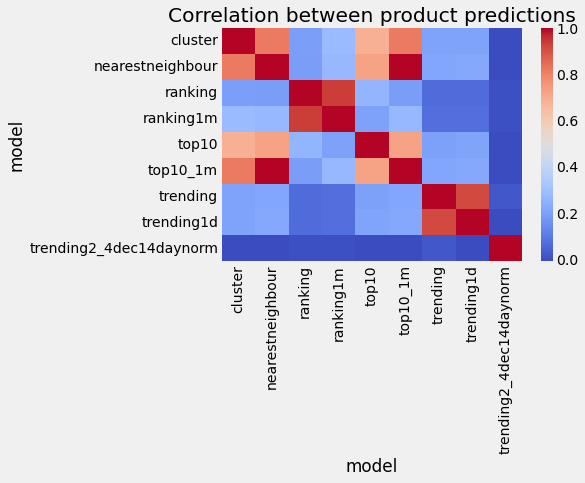

In [144]:
sns.heatmap(predict_all.pivot_table(index='cust_stock', 
                                    columns='model', 
                                    values='hit_rate').fillna(0).corr(),
            cmap='coolwarm').set(title='Correlation between product predictions')


Day difference between test invoice and preceeding invoice

In [323]:
inv_gap_list=[]
for i in test_invoices['customerid']:
    if sales_by_invoice[sales_by_invoice['customerid']==i].shape[0]>1:
        inv_gap = sales_by_invoice[sales_by_invoice['customerid']==i] \
            .sort_values(by='invoicedate')['invoicedate'].diff().tail(1).dt.days.values[0]
        inv_gap_list.append([i,inv_gap])

In [325]:
invoice_gaps = pd.DataFrame(inv_gap_list, columns=['customerid','time_gap'])

Aggregate test data to add into prediction dataset for comparison

In [364]:
# 
test_agg = test_data.groupby(['customerid','stockcode_caps'
                             ]).agg(predicted_revenue=('revenue',np.sum)).reset_index()

In [365]:
test_agg['cust_stock'] = test_agg['customerid'] + '/' + test_agg['stockcode_caps']

In [366]:
test_agg['model'] = 'testdata'

In [367]:
test_agg['hit_rate'] = True

In [368]:
predict_all = pd.concat([predict_all,test_agg])

In [369]:
predict_all.drop(columns=['recency_score', 'frequency_score',
       'monetary_score', 'cust_matrix', 'prodsales_deciles'],inplace=True,errors='ignore')

In [370]:
predict_all = predict_all.merge(customer_location[['customerid','recency_score','frequency_score',
                                     'monetary_score', 'cust_matrix']], 
                  on='customerid', 
                  how='left') \
            .merge(stock_descriptions[['stockcode_caps','prodsales_deciles']], 
                   on='stockcode_caps', 
                   how='left')

In [371]:
invoice_gaps

,customerid,time_gap
0,13015,143
1,14211,4
2,12463,6
3,16389,18
4,12794,45
...,...,...
1708,17581,0
1709,13777,0
1710,15804,10
1711,13113,14


In [372]:
predict_all = predict_all.merge(invoice_gaps, on='customerid', how='left')

In [373]:
predict_all['time_intervals'] = pd.cut(predict_all['time_gap'], 
                                       bins = [0,7,14,21,28,np.inf], 
                                       labels = ['<7days', '7-13days', '14-20days', 
                                                 '21-27days','>28days'],
                                       right = False)

In [374]:
predict_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285046 entries, 0 to 285045
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   customerid         285046 non-null  object  
 1   stockcode_caps     285046 non-null  object  
 2   model              285046 non-null  object  
 3   hit_rate           285046 non-null  bool    
 4   predicted_revenue  285046 non-null  float64 
 5   cust_stock         285046 non-null  object  
 6   time_gap_x         187616 non-null  float64 
 7   time_intervals     221062 non-null  category
 8   time_gap_y         187616 non-null  float64 
 9   recency_score      285046 non-null  float64 
 10  frequency_score    285046 non-null  float64 
 11  monetary_score     285046 non-null  float64 
 12  cust_matrix        285046 non-null  object  
 13  prodsales_deciles  285046 non-null  int64   
 14  time_gap           221062 non-null  float64 
dtypes: bool(1), category(1), float64(7

In [375]:
predict_all['time_intervals'] = predict_all['time_intervals'].astype('object')

In [376]:
predict_all['time_intervals'] = predict_all['time_intervals'].fillna('no_previous')

In [377]:
predict_all['model'].value_counts()

testdata                   118006
top10                       18560
ranking                     18560
ranking1m                   18560
nearestneighbour            18560
trending                    18560
trending1d                  18560
trending2_4dec14daynorm     18560
cluster                     18560
top10_1m                    18560
Name: model, dtype: int64

In [378]:
# Set float display options
pd.set_option('display.float_format','{:,.2f}'.format)

In [379]:
model_titles = ['cluster', 'nearestneighbour', 'ranking', 'ranking1m', 
                         'trending', 'trending1d','trending2_4dec14daynorm','top10_1m','testdata']

In [380]:
predict_all.groupby('model').agg(hit_rate=('hit_rate',np.mean),
                                predicted_revenue=('predicted_revenue',np.sum)) \
                                .reindex(index=model_titles)

,hit_rate,predicted_revenue
model,,
cluster,0.11,"125,274.45"
nearestneighbour,0.11,"120,728.90"
ranking,0.14,"128,063.58"
ranking1m,0.15,"142,207.14"
trending,0.05,"47,825.78"
trending1d,0.06,"49,723.74"
trending2_4dec14daynorm,0.02,"9,556.47"
top10_1m,0.11,"120,728.90"
testdata,1.00,"2,177,005.03"


In [381]:
time_interval_titles = ['<7days', '7-13days', '14-20days', '21-27days','>28days','no_previous']

In [382]:
predict_all.pivot_table(index='model', 
                        columns='time_intervals', 
                        values='hit_rate', 
                        aggfunc='mean',
                        margins=True).iloc[:-1,:].reindex(index=model_titles, 
                                                          columns=time_interval_titles)

time_intervals,<7days,7-13days,14-20days,21-27days,>28days,no_previous
model,,,,,,
cluster,0.07,0.09,0.10,0.09,0.08,0.43
nearestneighbour,0.07,0.09,0.11,0.10,0.08,0.43
ranking,0.09,0.11,0.13,0.14,0.14,0.36
ranking1m,0.09,0.11,0.13,0.14,0.14,0.43
trending,0.03,0.03,0.03,0.04,0.05,0.22
trending1d,0.03,0.03,0.04,0.04,0.05,0.24
trending2_4dec14daynorm,0.01,0.01,0.00,0.01,0.01,0.09
top10_1m,0.07,0.09,0.11,0.10,0.08,0.43
testdata,1.00,1.00,1.00,1.00,1.00,1.00


In [383]:
predict_all.pivot_table(index='prodsales_deciles', 
                        columns='model', 
                        values='hit_rate', 
                        aggfunc='mean',
                        margins=True).iloc[:,:-1].reindex(columns=model_titles)

model,cluster,nearestneighbour,ranking,ranking1m,trending,trending1d,trending2_4dec14daynorm,top10_1m,testdata
prodsales_deciles,,,,,,,,,
1,0.11,0.11,0.18,0.19,0.06,0.06,NaN,0.11,1.00
2,0.00,NaN,0.10,0.10,0.02,NaN,0.02,NaN,1.00
3,NaN,NaN,0.09,0.09,0.01,NaN,0.02,NaN,1.00
4,NaN,NaN,0.06,0.06,0.01,NaN,0.01,NaN,1.00
All,0.11,0.11,0.14,0.15,0.05,0.06,0.02,0.11,1.00


In [384]:
predict_all.pivot_table(index='prodsales_deciles', 
                        columns='model', 
                        values='predicted_revenue', 
                        aggfunc='sum',
                        margins='rows').iloc[:,:-1].reindex(columns=model_titles)

model,cluster,nearestneighbour,ranking,ranking1m,trending,trending1d,trending2_4dec14daynorm,top10_1m,testdata
prodsales_deciles,,,,,,,,,
1,"125,274.45","120,728.90","110,695.79","124,844.95","46,912.04","49,723.74",NaN,"120,728.90","1,444,789.87"
2,0.00,NaN,"10,520.55","10,512.75",750.76,NaN,"2,754.40",NaN,"390,294.34"
3,NaN,NaN,"4,550.90","4,553.10",114.70,NaN,"4,619.72",NaN,"210,744.70"
4,NaN,NaN,"2,296.34","2,296.34",48.28,NaN,"2,182.35",NaN,"131,176.12"
All,"125,274.45","120,728.90","128,063.58","142,207.14","47,825.78","49,723.74","9,556.47","120,728.90","2,177,005.03"


In [157]:
predict_all.pivot_table(index='cust_matrix', 
                        columns='model', 
                        values='hit_rate', 
                        aggfunc='mean',
                        margins=True).iloc[:,:-1].reindex(columns=model_titles)

model,cluster,nearestneighbour,ranking,ranking1m,trending,trending1d,trending2_4dec14daynorm,top10_1m,testdata
cust_matrix,,,,,,,,,
new_cust,0.35,0.35,0.32,0.37,0.14,0.16,0.06,0.35,1.00
problem_cust,0.11,0.11,0.15,0.15,0.08,0.08,0.02,0.11,1.00
star_cust,0.09,0.09,0.12,0.12,0.03,0.03,0.01,0.09,1.00
All,0.11,0.11,0.14,0.15,0.05,0.06,0.02,0.11,1.00


In [355]:
predict_all

,customerid,stockcode_caps,model,hit_rate,predicted_revenue,cust_stock,time_gap,time_intervals
0,13015,22423,top10,True,25.50,13015/22423,143.00,>28days
1,13015,85123A,top10,False,0.00,13015/85123A,143.00,>28days
2,13015,85099B,top10,False,0.00,13015/85099B,143.00,>28days
3,13015,47566,top10,False,0.00,13015/47566,143.00,>28days
4,13015,84879,top10,False,0.00,13015/84879,143.00,>28days
...,...,...,...,...,...,...,...,...
226038,12680,23355,top10_1m,False,0.00,12680/23355,72.00,>28days
226039,12680,85099B,top10_1m,False,0.00,12680/85099B,72.00,>28days
226040,12680,22910,top10_1m,False,0.00,12680/22910,72.00,>28days
226041,12680,22114,top10_1m,False,0.00,12680/22114,72.00,>28days


In [354]:
predict_all.pivot_table(index='cust_matrix', 
                        columns='model', 
                        values='predicted_revenue', 
                        aggfunc='sum',
                        margins='rows').iloc[:,:-1].reindex(columns=model_titles)

KeyError: 'cust_matrix'

In [159]:
predict_all.pivot_table(index='recency_score', 
                        columns='model', 
                        values='hit_rate', 
                        aggfunc='mean',
                        margins=True).iloc[:,:-1].reindex(columns=model_titles)

model,cluster,nearestneighbour,ranking,ranking1m,trending,trending1d,trending2_4dec14daynorm,top10_1m,testdata
recency_score,,,,,,,,,
2.0,0.11,0.11,0.15,0.15,0.08,0.08,0.02,0.11,1.00
3.0,0.11,0.11,0.14,0.14,0.04,0.04,0.01,0.11,1.00
All,0.11,0.11,0.14,0.15,0.05,0.06,0.02,0.11,1.00


In [353]:
predict_all.pivot_table(index='recency_score', 
                        columns='model', 
                        values='predicted_revenue', 
                        aggfunc='sum',
                        margins='rows').iloc[:,:-1].reindex(columns=model_titles)

KeyError: 'recency_score'

In [161]:
predict_all.pivot_table(index='frequency_score', 
                        columns='model', 
                        values='hit_rate', 
                        aggfunc='mean',
                        margins=True).iloc[:,:-1].reindex(columns=model_titles)

model,cluster,nearestneighbour,ranking,ranking1m,trending,trending1d,trending2_4dec14daynorm,top10_1m,testdata
frequency_score,,,,,,,,,
1.0,0.11,0.11,0.10,0.11,0.04,0.04,0.02,0.11,1.00
2.0,0.18,0.19,0.22,0.25,0.10,0.11,0.03,0.19,1.00
3.0,0.09,0.09,0.12,0.12,0.04,0.04,0.01,0.09,1.00
All,0.11,0.11,0.14,0.15,0.05,0.06,0.02,0.11,1.00


In [162]:
predict_all.pivot_table(index='frequency_score', 
                        columns='model', 
                        values='predicted_revenue', 
                        aggfunc='sum',
                        margins='rows').iloc[:,:-1].reindex(columns=model_titles)

model,cluster,nearestneighbour,ranking,ranking1m,trending,trending1d,trending2_4dec14daynorm,top10_1m,testdata
frequency_score,,,,,,,,,
1.0,"1,440.82","1,440.82","1,351.13","1,440.82",208.07,225.92,153.85,"4,322.46","23,984.71"
2.0,"70,151.36","69,708.95","62,337.39","76,737.00","32,662.28","33,700.51","3,460.37","209,126.85","555,612.70"
3.0,"53,682.27","49,579.13","64,375.06","64,029.32","14,955.43","15,797.31","5,942.25","148,737.39","508,905.11"
All,"125,274.45","120,728.90","128,063.58","142,207.14","47,825.78","49,723.74","9,556.47","362,186.70","1,088,502.51"


In [163]:
predict_all.pivot_table(index='monetary_score', 
                        columns='model', 
                        values='hit_rate', 
                        aggfunc='mean',
                        margins=True).iloc[:,:-1].reindex(columns=model_titles)

model,cluster,nearestneighbour,ranking,ranking1m,trending,trending1d,trending2_4dec14daynorm,top10_1m,testdata
monetary_score,,,,,,,,,
2.0,0.07,0.07,0.13,0.13,0.03,0.04,0.01,0.07,1.00
3.0,0.13,0.14,0.15,0.16,0.06,0.07,0.02,0.14,1.00
All,0.11,0.11,0.14,0.15,0.05,0.06,0.02,0.11,1.00


In [164]:
predict_all.pivot_table(index='monetary_score', 
                        columns='model', 
                        values='predicted_revenue', 
                        aggfunc='sum',
                        margins='rows').iloc[:,:-1].reindex(columns=model_titles)

model,cluster,nearestneighbour,ranking,ranking1m,trending,trending1d,trending2_4dec14daynorm,top10_1m,testdata
monetary_score,,,,,,,,,
2.0,"11,287.18","10,759.71","20,667.51","20,877.02","4,071.99","4,296.11",989.17,"32,279.13","157,151.42"
3.0,"113,987.27","109,969.19","107,396.07","121,330.12","43,753.79","45,427.63","8,567.30","329,907.57","931,351.10"
All,"125,274.45","120,728.90","128,063.58","142,207.14","47,825.78","49,723.74","9,556.47","362,186.70","1,088,502.51"


Combine prediction ranking decay 1m and trending
ranking decay 1m try range of products
get optimum
then add in trending thats not in original list

In [165]:
predict_data = personalized_ranking(revenue='revenue_decay_1M',num_predict=10,model_name='ranking_10')

In [166]:
# create dataframe to store all predictions
predict_rankings = predict_data[['customerid','stockcode_caps','model','hit_rate','predicted_revenue']]

# view prediction hit rate and predicted revenue
predict_rankings.groupby('model').agg(hit_rate = ('hit_rate',np.mean),
                                   predicted_revenue = ('predicted_revenue',np.sum))

,hit_rate,predicted_revenue
model,,
ranking_10,0.15,"142,207.14"


In [167]:
predict_data = personalized_ranking(revenue='revenue_decay_1M',num_predict=9,model_name='ranking_09')

In [168]:
predict_rankings = pd.concat([predict_rankings, predict_data], join = 'inner', ignore_index=True)

In [169]:
predict_data = personalized_ranking(revenue='revenue_decay_1M',num_predict=8,model_name='ranking_08')

In [170]:
predict_rankings = pd.concat([predict_rankings, predict_data], join = 'inner', ignore_index=True)

In [171]:
# view prediction hit rate and predicted revenue
predict_rankings.groupby('model').agg(hit_rate = ('hit_rate',np.mean),
                                   predicted_revenue = ('predicted_revenue',np.sum))

,hit_rate,predicted_revenue
model,,
ranking_08,0.15,"123,124.80"
ranking_09,0.15,"131,893.42"
ranking_10,0.15,"142,207.14"


In [172]:
predict_data = personalized_ranking(revenue='revenue_decay_1M',num_predict=7,model_name='ranking_07')

In [173]:
predict_rankings = pd.concat([predict_rankings, predict_data], join = 'inner', ignore_index=True)

In [174]:
predict_data = personalized_ranking(revenue='revenue_decay_1M',num_predict=6,model_name='ranking_06')

In [175]:
predict_rankings = pd.concat([predict_rankings, predict_data], join = 'inner', ignore_index=True)

In [176]:
predict_data = personalized_ranking(revenue='revenue_decay_1M',num_predict=5,model_name='ranking_05')

In [177]:
predict_rankings = pd.concat([predict_rankings, predict_data], join = 'inner', ignore_index=True)

In [178]:
ranking_summary = predict_rankings.groupby('model').agg(hit_rate = ('hit_rate',np.mean),
                                   predicted_revenue = ('predicted_revenue',np.sum))

In [179]:
ranking_summary.diff()

,hit_rate,predicted_revenue
model,,
ranking_05,NaN,NaN
ranking_06,-0.00,"16,537.70"
ranking_07,-0.00,"10,588.34"
ranking_08,0.00,"9,975.37"
ranking_09,-0.00,"8,768.62"
ranking_10,-0.00,"10,313.72"
